# PROJET 4 : Anticipez les besoins en consommation de bâtiments

Vous travaillez pour la ville de Seattle. Pour atteindre son objectif de ville neutre en émissions de carbone en 2050, votre équipe s’intéresse de près à la consommation et aux émissions des bâtiments non destinés à l’habitation.


Des relevés minutieux ont été effectués par les agents de la ville en 2016. Voici les données et leur source. Cependant, ces relevés sont coûteux à obtenir, et à partir de ceux déjà réalisés, vous voulez tenter de prédire les émissions de CO2 et la consommation totale d’énergie de bâtiments non destinés à l’habitation pour lesquels elles n’ont pas encore été mesurées.

Votre prédiction se basera sur les données structurelles des bâtiments (taille et usage des bâtiments, date de construction, situation géographique, ...)

Vous cherchez également à évaluer l’intérêt de l’"ENERGY STAR Score" pour la prédiction d’émissions, qui est fastidieux à calculer avec l’approche utilisée actuellement par votre équipe. Vous l'intégrerez dans la modélisation et jugerez de son intérêt.

Vous sortez tout juste d’une réunion de brief avec votre équipe. Voici un récapitulatif de votre mission :

Réaliser une courte analyse exploratoire.
Tester différents modèles de prédiction afin de répondre au mieux à la problématique.
Avant de quitter la salle de brief, Douglas, le project lead, vous donne quelques pistes et erreurs à éviter :

""Douglas : L’objectif est de te passer des relevés de consommation annuels futurs (attention à la fuite de données). Nous ferons de toute façon pour tout nouveau bâtiment un premier relevé de référence la première année, donc rien ne t'interdit d’en déduire des variables structurelles aux bâtiments, par exemple la nature et proportions des sources d’énergie utilisées.. 

Fais bien attention au traitement des différentes variables, à la fois pour trouver de nouvelles informations (peut-on déduire des choses intéressantes d’une simple adresse ?) et optimiser les performances en appliquant des transformations simples aux variables (normalisation, passage au log, etc.).

Mets en place une évaluation rigoureuse des performances de la régression, et optimise les hyperparamètres et le choix d’algorithmes de ML à l’aide d’une validation croisée.""

# Sommaire

## I. Importation des données

### 1. Importation des bibliothèques
### 2. Importation du fichier

## II. Préparation du jeu de données

### 1. Séparation du jeu de données
### 2. Encodage et standardisation


## III. Modélisation

### 1. Régression Linéaire
###     Analyse des régulateurs
##### a. Regression Ridge
##### b. Lasso
##### c Elastic Net

### 2. Arbre de décisions

### 3. XGBoost

### 4. Random Forest



## IV. Analyse des modélisations

###  Analyse des résultats



## V. Optimisation des modèles

### 1. Cross Validation
### 2. GridSearch CV
### 3. Analyse de l'apport des variables sur nos modèles

# 

## I. Importation des données

### 1. Importation des bibliothèques

In [1]:
# Importation bibliothèque

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import time
import shap
import warnings
warnings.filterwarnings('ignore')


# Preprocessing
from sklearn.preprocessing import StandardScaler, OneHotEncoder,OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import VarianceThreshold


# Séparation du jeu de données
from sklearn.model_selection import train_test_split

# Modélisation
from sklearn.linear_model import LinearRegression
from sklearn import linear_model

from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree

from sklearn.ensemble import GradientBoostingRegressor

from sklearn.svm import SVR
from sklearn.svm import SVC

from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import TransformedTargetRegressor

# Mesures de performances
from sklearn.metrics import *
from sklearn import metrics
from sklearn.metrics import r2_score 
from sklearn.metrics import mean_squared_error

# Tests avec un régulateur pour la Régression Linéaire
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet

# Optimisation du modèle
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import validation_curve
from sklearn.model_selection import GridSearchCV




In [2]:
start = time.perf_counter()

end = time.perf_counter()

# 

### 2. Importation du fichier

In [3]:
data = pd.read_csv('data_clean_final.csv')


Dans le cadre de notre première modélisation, nous allons effectuer le premier modèle sans le EnergyStarScore.
Nous allons supprimer la colonne puis supprimer les lignes manquantes

In [4]:
#sauvegarde séparée du energy star score
energy_star = data[['ENERGYSTARScore']]
data.drop(columns = ['ENERGYSTARScore', 'SiteEUIWN(kBtu/sf)', 'SourceEUIWN(kBtu/sf)',
                   'SteamUse(kBtu)', 'Electricity(kBtu)', 'NaturalGas(kBtu)'], inplace=True)

In [5]:
data.isnull().sum()

NumberofBuildings         0
NumberofFloors            0
Neighborhood              0
PropertyGFAParking        0
%_stream                  0
BuildingType              0
PrimaryPropertyType       0
GHGEmissionsIntensity     0
Age_batiment              0
%_elec                    0
%_gaz                     0
PropertyGFATotal          0
PropertyGFABuilding(s)    0
SiteEnergyUse(kBtu)       0
TotalGHGEmissions         0
dtype: int64

In [6]:
data.dtypes

NumberofBuildings         float64
NumberofFloors            float64
Neighborhood               object
PropertyGFAParking        float64
%_stream                  float64
BuildingType               object
PrimaryPropertyType        object
GHGEmissionsIntensity     float64
Age_batiment                int64
%_elec                    float64
%_gaz                     float64
PropertyGFATotal          float64
PropertyGFABuilding(s)    float64
SiteEnergyUse(kBtu)       float64
TotalGHGEmissions         float64
dtype: object

# 

## II. Préparation du jeu de données

### 1. Séparation du jeu de données

In [7]:
# Création du train_test_split

y = data['SiteEnergyUse(kBtu)']
X = data.drop(['SiteEnergyUse(kBtu)','GHGEmissionsIntensity', 'TotalGHGEmissions'], axis=1)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 100)

display('Données entrainements : ',X_train.shape, X_test.shape)
display('Données de test',y_train.shape, y_test.shape)

'Données entrainements : '

(1207, 12)

(403, 12)

'Données de test'

(1207,)

(403,)

# 

### 2. Encodage et standardisation

In [8]:
# Sélection des variables qualitatives et quantitatives

numeric = X_train.select_dtypes(['float64', 'int64']).columns
normalisation=StandardScaler()

# Utilisation du OneHot    
categ=X_train.select_dtypes('object').columns
OneHot=OneHotEncoder(handle_unknown='ignore',sparse=False)


preprocessor = ColumnTransformer(transformers=[ ('num', normalisation, numeric),
                                                ('cat', OneHot, categ)])

In [9]:
# Apprentissage de l'encodage et transformation des données d'entrainement
X_train=preprocessor.fit_transform(X_train)

# Récupération des noms des variables encodeés
encoded_names=numeric.to_list()
encoded_Cat_names=preprocessor.named_transformers_['cat'].get_feature_names(categ).tolist()
encoded_names.extend(encoded_Cat_names)

In [10]:
# Application du transformer déjà entrainé sur les données de test
X_test= preprocessor.transform(X_test)

In [11]:
# création des data frame contenant les jeux encodés
encoded_X_train=pd.DataFrame(X_train,columns=encoded_names)
encoded_X_test=pd.DataFrame(X_test,columns=encoded_names)

In [12]:
# creating set to hold the correlated features
corr_features = set()

# create the correlation matrix (default to pearson)
corr_matrix = encoded_X_train.corr()

# optional: display a heatmap of the correlation matrix
# plt.figure(figsize=(11,11))
# sns.heatmap(corr_matrix)

for i in range(len(corr_matrix .columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > 0.70:  #0.90 pour memoire essai à 0.80
            colname = corr_matrix.columns[i]
            corr_features.add(colname)
            
corr_features

{'%_gaz',
 'BuildingType_Nonresidential COS',
 'PrimaryPropertyType_School',
 'PropertyGFABuilding(s)'}

In [13]:

encoded_X_train.drop(labels=corr_features, axis=1, inplace=True)
encoded_X_test.drop(labels=corr_features, axis=1, inplace=True)

In [14]:

var = VarianceThreshold(threshold=0).fit(encoded_X_train)

low_var = var.get_support(indices=False)

low_var_encoded_X_train=encoded_X_train.loc[:,low_var]
low_var_encoded_X_test=encoded_X_test.loc[:,low_var]
low_var_encoded_X_train.head(5)

,NumberofBuildings,NumberofFloors,PropertyGFAParking,%_stream,Age_batiment,%_elec,PropertyGFATotal,Neighborhood_BALLARD,Neighborhood_CENTRAL,Neighborhood_DELRIDGE,...,BuildingType_NonResidential,BuildingType_SPS-District K-12,PrimaryPropertyType_Hotel,PrimaryPropertyType_Medical Center,PrimaryPropertyType_Mixed Use Property,PrimaryPropertyType_Office,PrimaryPropertyType_Other,PrimaryPropertyType_Store,PrimaryPropertyType_University,PrimaryPropertyType_Warehouse
0,-0.119315,2.925536,2.388477,-0.21906,-1.142976,0.729951,2.698065,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,-0.119315,3.845430,2.383877,-0.21906,-0.570814,1.106593,2.698065,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,-0.119315,2.381561,2.300979,-0.21906,-0.841838,1.078431,2.359512,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,-0.119315,-0.354715,-0.501054,-0.21906,1.175784,1.106592,-1.168155,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,-0.119315,0.099094,-0.501054,-0.21906,0.964988,-1.831616,-1.195007,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [15]:
X_train=low_var_encoded_X_train
X_test=low_var_encoded_X_test

## III. Modélisation

## 1. Régression Linéaire

In [16]:
# Création du modèle
model1 = LinearRegression()

# Entrainement du modèle
model1.fit(X_train, y_train)


# maintenant on va faire la prédiction
prediction = model1.predict(X_test)

# on va afficher le % d'apprentissage du modèle
A1 = model1.score(X_train, y_train)
print ("Le score d'apprentissage est de : ", A1)


R1 = model1.score(X_test, y_test)
print("Le score de test est de : ",R1)

T1 = end-start
print("La durée de chargement de la cellule est de : ", T1)

Le score d'apprentissage est de :  0.6655814531771953
Le score de test est de :  0.7173755555318069
La durée de chargement de la cellule est de :  6.699999999959516e-05


In [17]:
# ON VA CALCULER LE B dans y = ax + b
print (model1.intercept_)

# on va calculer les coefficients de la droite
model1.coef_

14.93201726185779


array([ 0.01911592,  0.0146234 , -0.05327188,  0.03625282, -0.12467764,
       -0.17921055,  0.87682971, -0.12202322,  0.00351628,  0.10098814,
        0.10756709, -0.0516096 ,  0.05541326,  0.09104672,  0.02418973,
       -0.0972801 ,  0.06759346, -0.13024592, -0.1013103 ,  0.05215447,
       -0.21657114, -0.4504354 ,  0.22206601,  0.64567454,  0.18139013,
        0.14072127,  0.3164786 ,  0.59091886,  0.17258034, -0.57817091])

Text(0.5, 1.0, 'Analyse du modèle linéaire')

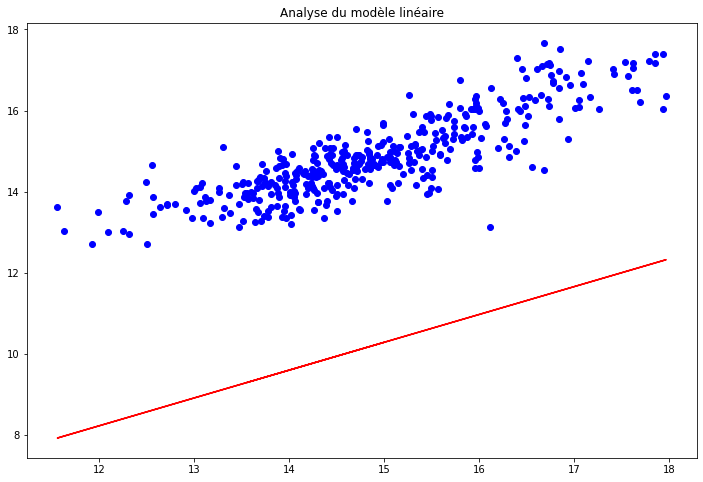

In [18]:
# on va construire la droite Y = m*X + b ET DONC FINALISER
plt.figure (figsize = (12,8))
m, b = np.polyfit (y_test, prediction, 1)
plt.plot(y_test, prediction, 'bo', y_test, m*y_test, 'r')
plt.title('Analyse du modèle linéaire')

## Analyse des erreurs avec les métriques

In [19]:
# MAE

MAE1 = mean_absolute_error(y_test, prediction)
      
# MSE

MSE1 = mean_squared_error(y_test, prediction)

Nous avons ici testé le MAE et le MSE, nous constatons un écart important entre les deux variables.

Afin de sélectionner le meilleur paramètres, il est important de connaître la différence entre les deux méthodes :

- MAE : l'importance de l'erreur est linéaire avec son amplitude. A sélectionner si le Dataset contient des valeurs aberrantes.

- MSE : nous accordons une grande importance aux grandes erreurs.


### Analyse des régulateurs

Afin de procéder à une analyse plus poussée, nous allons procéder à une utilisation des régulateurs. Nous allons utiliser le modèle du Lasso et celui du Regression Ridge.

Regression ridge : ce modèle a pour but de réduire l'amplitude des coefficients de la la régression linéaire.

Lasso : ce modèle a pour objectif d' annuler certains coefficients. Les variables qui auront un coefficient égal à zéro ne feront plus partie du modèle, qui en sera simplifié d'autant. Un tel modèle, avec beaucoup de coefficients nuls, est appelé un modèle parcimonieux. Il s'agit donc d'une méthode de sélection de variables et de réduction de dimension supervisée : les variables qui ne sont pas nécessaires à la prédiction de l'étiquette sont éliminées.

#### A. Régression Ridge

In [20]:
# On crée un modèle de régression linéaire
lr = linear_model.LinearRegression()

# On entraîne ce modèle sur les données d'entrainement
lr.fit(X_train,y_train)

# On récupère l'erreur de norme 2 sur le jeu de données test comme baseline
baseline_error = np.mean((lr.predict(X_test) - y_test) ** 2)

print(baseline_error)

0.4412479108303776


In [21]:
# On récupère l'erreur de norme 2 sur le jeu de données test comme baseline
baseline_error = np.mean((model1.predict(X_test) - y_test) ** 2)

print('Notre erreur quadratique est : ', baseline_error)

Notre erreur quadratique est :  0.4412479108303776


In [22]:
# Application du regression ridge

n_alphas = 200
alphas = np.logspace(-5, 5, n_alphas)

ridge = linear_model.Ridge()

coefs = []
errors = []
for a in alphas:
    ridge.set_params(alpha=a)
    ridge.fit(X_train, y_train)
    coefs.append(ridge.coef_)
    errors.append([baseline_error, np.mean((ridge.predict(X_test) - y_test) ** 2)])

prediction2 = ridge.predict(X_test)
    # on va afficher le % d'apprentissage du modèle
A2 = ridge.score(X_train, y_train)
print ("Le score d'apprentissage est de : ", A2)


R2 = ridge.score(X_test, y_test)
print("Le score de test est de : ",R2)

T2 = end-start
print("La durée de chargement de la cellule est de : ", T2)

Le score d'apprentissage est de :  0.02408107010095084
Le score de test est de :  0.02557594218193404
La durée de chargement de la cellule est de :  6.699999999959516e-05


In [23]:
# MAE

MAE2 = mean_absolute_error(y_test, prediction2)
      
# MSE

MSE2 = mean_squared_error(y_test, prediction2)

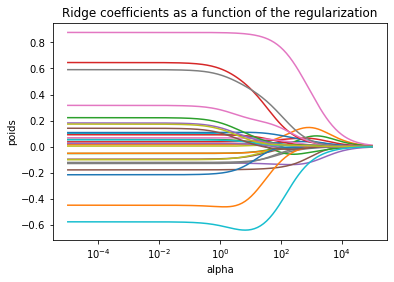

In [24]:
ax = plt.gca()

ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('poids')
plt.title('Ridge coefficients as a function of the regularization')
plt.axis('tight')
plt.show()

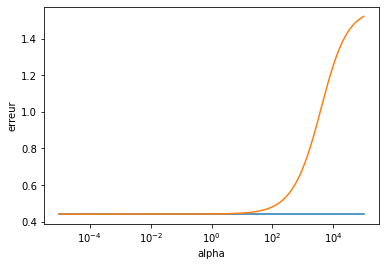

In [25]:
ax = plt.gca()

ax.plot(alphas, errors)
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('erreur')
plt.axis('tight')
plt.show()

In [26]:
min(errors)

[0.4412479108303776, 0.4412479184237351]

#### B.  Lasso

In [27]:
n_alphas = 300
alphas = np.logspace(-5, 5, n_alphas)
lasso = linear_model.Lasso(fit_intercept=False)

coefs = []
errors = []
for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(X_train, y_train)
    coefs.append(lasso.coef_)
    errors.append([baseline_error, np.mean((lasso.predict(X_test) - y_test) ** 2)])
    
prediction3 = lasso.predict(X_test)
    
        # on va afficher le % d'apprentissage du modèle
A3 = lasso.score(X_train, y_train)
print ("Le score d'apprentissage est de : ", A3)


R3 = lasso.score(X_test, y_test)
print("Le score de test est de : ",R3)

T3 = end-start
print("La durée de chargement de la cellule est de : ", T3)

Le score d'apprentissage est de :  -143.71861594757223
Le score de test est de :  -141.82210852046757
La durée de chargement de la cellule est de :  6.699999999959516e-05


In [28]:
# MAE

MAE3 = mean_absolute_error(y_test, prediction3)
      
# MSE

MSE3 = mean_squared_error(y_test, prediction3)

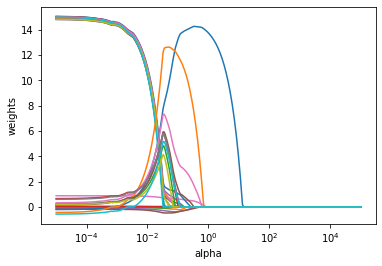

In [29]:
ax = plt.gca()

ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('weights')
plt.axis('tight')
plt.show()

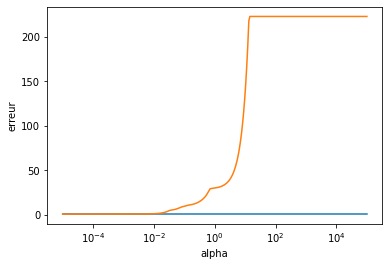

In [30]:
ax = plt.gca()

ax.plot(alphas, errors)
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('erreur')
plt.axis('tight')
plt.show()

In [31]:
min(errors)

[0.4412479108303776, 0.44126130432145033]

#### C. Elastic Net

In [32]:
n_alphas = 300
alphas = np.logspace(-5, 5, n_alphas)

modelelastic = ElasticNet(alpha=0.1, l1_ratio=0.9, selection='random', random_state=42)

coefs = []
errors = []
for a in alphas:
    modelelastic.set_params(alpha=a)
    modelelastic.fit(X_train, y_train)
    coefs.append(modelelastic.coef_)
    errors.append([baseline_error, np.mean((modelelastic.predict(X_test) - y_test) ** 2)])
    
    prediction4 = modelelastic.predict(X_test)
    # on va afficher le % d'apprentissage du modèle
A4 =     modelelastic.set_params(alpha=a).score(X_train, y_train)
print ("Le score d'apprentissage est de : ", A4)


R4 =     modelelastic.set_params(alpha=a).score(X_test, y_test)
print("Le score de test est de : ",R4)

T4 = end-start
print("La durée de chargement de la cellule est de : ", T4)

Le score d'apprentissage est de :  0.0
Le score de test est de :  -0.000624543976759151
La durée de chargement de la cellule est de :  6.699999999959516e-05


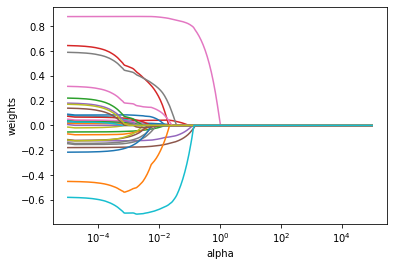

In [33]:
ax = plt.gca()

ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('weights')
plt.axis('tight')
plt.show()

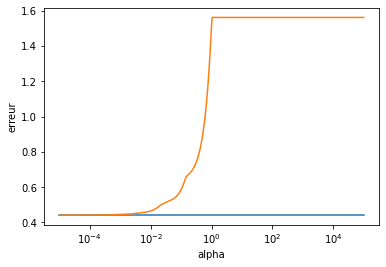

In [34]:
ax = plt.gca()

ax.plot(alphas, errors)
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('erreur')
plt.axis('tight')
plt.show()

In [35]:
# MAE

MAE4 = mean_absolute_error(y_test, prediction4)
      
# MSE

MSE4 = mean_squared_error(y_test, prediction4)

## Analyse des régulateurs

In [36]:
A = [A1, A2, A3, A4]
R = [R1, R2, R3, R4]
T = [T1, T2, T3, T4]
MAE = [MAE1, MAE2, MAE3, MAE4]
MSE = [MSE1, MSE2, MSE3, MSE4]

indice = ['Modele linéaire', 'Regression Ridge', 'Lasso', 'Elastic']


data_lineaire = pd.DataFrame ({'Score Apprentissage': A,'Score Test' : R, 'MAE':MAE, 'MSE':MSE, 'Temps':T}, index = indice)
data_lineaire

,Score Apprentissage,Score Test,MAE,MSE,Temps
Modele linéaire,0.665581,0.717376,0.507176,0.441248,0.000067
Regression Ridge,0.024081,0.025576,0.989841,1.521321,0.000067
Lasso,-143.718616,-141.822109,14.880189,222.981268,0.000067
Elastic,0.000000,-0.000625,1.002876,1.562227,0.000067


Nous pouvons constater que seul le modèle linéaire répond à notre problématique, nous allons conserver ce dernier dans le cadre d'une analyse de nos résultats pour notre problématique.

# 

### 2. Arbre de décisions

In [37]:
model5 = tree.DecisionTreeRegressor(max_depth = 6, random_state = 1)

model5.fit(X_train, y_train)

prediction5 = model5.predict(X_test)

# on va afficher le % d'apprentissage du modèle
A5 = model5.score(X_train, y_train)
print ("Le score d'apprentissage est de : ", A5)


R5 = model5.score(X_test, y_test)
print("Le score de test est de : ",R5)

T5 = end-start
print("La durée de chargement de la cellule est de : ", T5)

Le score d'apprentissage est de :  0.7340787035982328
Le score de test est de :  0.6524167976172734
La durée de chargement de la cellule est de :  6.699999999959516e-05


In [38]:
# MAE

MAE5 = mean_absolute_error(y_test, prediction5)
      
# MSE

MSE5 = mean_squared_error(y_test, prediction5)

### 3. XGBoost

In [39]:
model6 = GradientBoostingRegressor(n_estimators = 100, learning_rate = 0.36)
model6.fit(X_train, y_train)

prediction6 = model6.predict(X_test)


# on va afficher le % d'apprentissage du modèle
A6 = model6.score(X_train, y_train)
print ("Le score d'apprentissage est de : ", A6)


R6 = model6.score(X_test, y_test)
print("Le score de test est de : ",R6)

T6 = end-start
print("La durée de chargement de la cellule est de : ", T6)

Le score d'apprentissage est de :  0.8980629370215572
Le score de test est de :  0.7269049002660625
La durée de chargement de la cellule est de :  6.699999999959516e-05


In [40]:
# MAE

MAE6 = mean_absolute_error(y_test, prediction6)
      
# MSE

MSE6 = mean_squared_error(y_test, prediction6)

In [41]:
dataprediction = pd.DataFrame({'Consommation réelle':y_test, 'Consommation prédite':prediction6})
dataprediction

,Consommation réelle,Consommation prédite
204,13.562230,13.137630
1395,16.321071,15.633796
767,14.665335,14.182692
1167,15.590974,14.761528
590,14.363980,13.437363
...,...,...
1472,16.663602,16.219807
1083,15.395402,15.699953
642,14.447589,14.735289
955,15.066299,15.302801


Text(0.5, 1.0, 'Analyse de la prédiction du XGBoost')

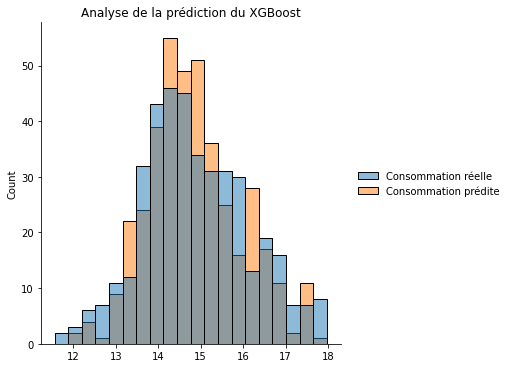

In [42]:
sns.displot(dataprediction)
plt.title('Analyse de la prédiction du XGBoost')

Text(0.5, 1.0, 'Analyse du XGBoost')

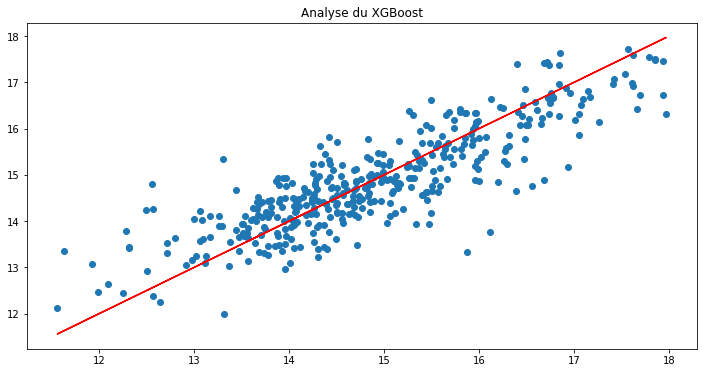

In [43]:
plt.figure(figsize = (12,6))

plt.scatter(y_test, prediction6)

plt.plot(y_test, y_test, 'r')
plt.title('Analyse du XGBoost')

# 

### 4. Random Forest

In [44]:
%%time

model7 = RandomForestRegressor(n_estimators = 100, max_depth = 6)
model7.fit(X_train, y_train)

prediction7 = model7.predict(X_test)

# on va afficher le % d'apprentissage du modèle
A7 = model7.score(X_train, y_train)
print ("Le score d'apprentissage est de : ", A5)


R7 = model7.score(X_test, y_test)
print("Le score de test est de : ",R7)

T7 = start
print("La durée de chargement de la cellule est de : ", T7)

Le score d'apprentissage est de :  0.7340787035982328
Le score de test est de :  0.7104736252003494
La durée de chargement de la cellule est de :  14.9748397
Wall time: 492 ms


In [45]:
# MAE

MAE7 = mean_absolute_error(y_test, prediction7)
      
# MSE

MSE7 = mean_squared_error(y_test, prediction7)

In [46]:
dataprediction2 = pd.DataFrame({'Consommation réelle':y_test, 'Consommation prédite':prediction7})
dataprediction2

,Consommation réelle,Consommation prédite
204,13.562230,13.625307
1395,16.321071,15.363126
767,14.665335,14.015895
1167,15.590974,14.624077
590,14.363980,13.739795
...,...,...
1472,16.663602,16.477947
1083,15.395402,15.753591
642,14.447589,14.910486
955,15.066299,15.407564


Text(0.5, 1.0, 'Analyse de la prédiction du Random Forest')

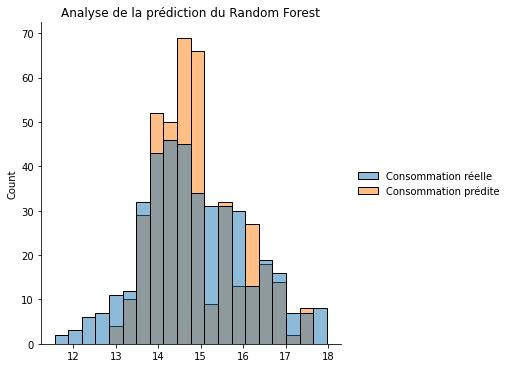

In [47]:
sns.displot(dataprediction2)
plt.title('Analyse de la prédiction du Random Forest')

Text(0.5, 1.0, 'Analyse de la prédiction du Random Forest')

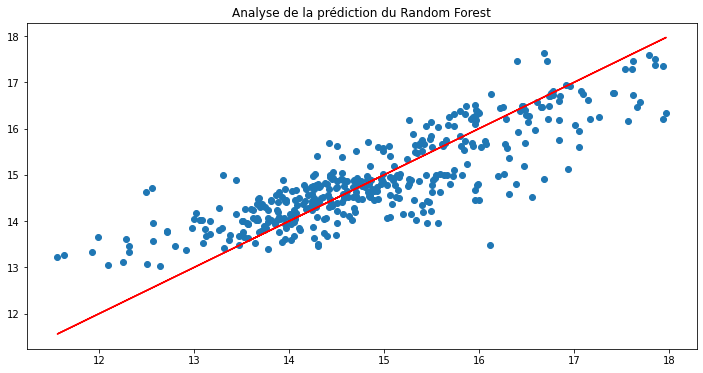

In [48]:
plt.figure(figsize = (12,6))

plt.scatter(y_test, prediction7)

plt.plot(y_test, y_test, 'r')
plt.title('Analyse de la prédiction du Random Forest')

# IV. Analyse des modélisations

### 1. Analyse des résultats

Nous allons créer un Dataset avec nos modélisations.
Nous avons pu constater que le SVR ressort avec un score négatif, nous allons l'exclure de notre fichier.

In [49]:
%%time

A = [A1, A5, A6, A7]
R = [R1, R5, R6, R7]
T = [T1, T5, T6, T7]
MAE = [MAE1, MAE5, MAE6, MAE7]
MSE = [MSE1, MSE5, MSE6, MSE7]

indice = ['Modele linéaire', 'Arbre de Décision', 'XGBoost', 'Random Forest']


data_analyse = pd.DataFrame ({'Score Apprentissage': A,'Score Test' : R, 'MAE':MAE, 'MSE':MSE, 'Temps':T}, index = indice)
data_analyse

Wall time: 999 µs


,Score Apprentissage,Score Test,MAE,MSE,Temps
Modele linéaire,0.665581,0.717376,0.507176,0.441248,0.000067
Arbre de Décision,0.734079,0.652417,0.558938,0.542665,0.000067
XGBoost,0.898063,0.726905,0.501337,0.426370,0.000067
Random Forest,0.764532,0.710474,0.509877,0.452024,14.974840


Suite à l'obtention de nos données. Nous pouvons constater que l'arbre de décision présente le plus faible niveau de prédiction.

Nos modèles linéaires, XGBoost et le Random Foresr présente les meilleurs résultats.
Dans le cadre d'une optimisation de nos paramètres, nous allons prendre la décision de travailler sur le XGBoost.

Text(0.5, 1.0, 'Représentation du MSE pour nos modèles')

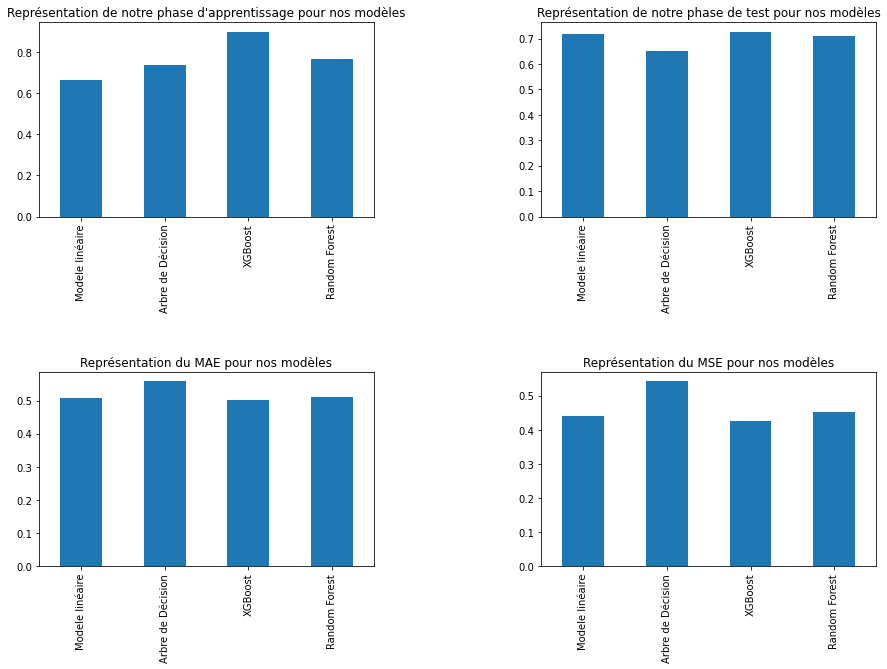

In [50]:
plt.figure (figsize = (15,10))
plt.subplots_adjust(hspace = 0.8, wspace = 0.5)

plt.subplot(2, 2, 1)
data_analyse['Score Apprentissage'].plot(kind = 'bar')
plt.title("Représentation de notre phase d'apprentissage pour nos modèles")

plt.subplot(2, 2, 2)
data_analyse['Score Test'].plot(kind = 'bar')
plt.title("Représentation de notre phase de test pour nos modèles")

plt.subplot(2, 2, 3)
data_analyse['MAE'].plot(kind = 'bar')
plt.title("Représentation du MAE pour nos modèles")

plt.subplot(2, 2, 4)
data_analyse['MSE'].plot(kind = 'bar')
plt.title("Représentation du MSE pour nos modèles")

Dans le cadre de notre analyse, nous pouvons constater que le modèle linéaire, le modèle XGBoost et le RandomForest ont une prédiction assez proche. Le XGBoost semble avoir un score très légérement supérieur, nous allons donc conserver ce dernier et tenter d'améliorer ce dernier à travers une optimisation des paramètres.

# V. Optimisation des modèles

### 1.Cross Validation

In [51]:
cross_val_score(GradientBoostingRegressor(), X_train, y_train, cv = 5).mean()

0.6860623371229109

In [52]:
%%time

est = [20, 100, 300, 500, 700, 900,1000]
score_apprentissage, score_validation = validation_curve(model6, X_train, y_train,
                                                        param_name = 'n_estimators',
                                                        param_range = est, cv = 5)

Wall time: 32 s


In [53]:
score_validation.mean(axis = 1)

array([0.67747588, 0.65381087, 0.61698856, 0.60463675, 0.59648583,
       0.58906759, 0.5862232 ])

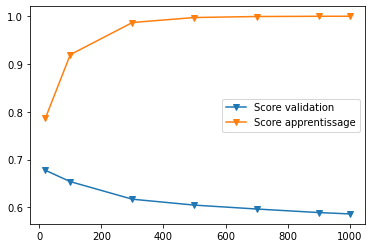

In [54]:
plt.plot(est, score_validation.mean(axis = 1), marker = 'v', label = 'Score validation')
plt.plot(est, score_apprentissage.mean(axis = 1), marker = 'v', label = 'Score apprentissage')
plt.legend()

In [55]:
%%time

est = [0.001, 0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.4]
score_apprentissage, score_validation = validation_curve(model6, X_train, y_train,
                                                        param_name = 'learning_rate',
                                                        param_range = est, cv = 10)

Wall time: 18.9 s


In [56]:
score_validation.mean(axis = 1)

array([0.09920254, 0.52366693, 0.67490193, 0.68084693, 0.68280219,
       0.68237335, 0.67461008, 0.65322201, 0.638603  ])

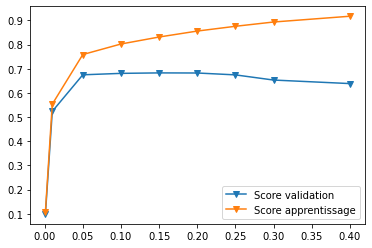

In [57]:
plt.plot(est, score_validation.mean(axis = 1), marker = 'v', label = 'Score validation')
plt.plot(est, score_apprentissage.mean(axis = 1), marker = 'v', label = 'Score apprentissage')
plt.legend()

Dans le cadre de notre Cross-Validation, nous pouvons constater les données suivantes :
    
    - les paramètres n_estimators et learning rate ont un score d'apprentissage qui ne parvient pas à dépasser 0.70, nous pouvons remarquer que notre modèle est en overfitting (surapprentissage),
    - le meilleur niveau de paramètre pour n_estimators semble se situer entre 10 et 200,
    - le meilleur niveau de paramètre pour learning rate semble être entre 0.05 et 0.25 mais aucune évolution majeure n'apparaît ici.
    
Nous allons toutefois tester nos paramètres suivants afin de voir si nous avons la possibilité d'améliorer notre modèle existant. Le cas échéant, il sera plus intéressant de procéder à une conservation des paramètres existants voir de conserver les données par défaut.

### 2 GridSearch CV

In [58]:
# Sélection de nos meilleurs paramètres

grid_param = {'n_estimators': [20, 40, 60, 80, 100],
             'learning_rate': [0.1, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2]}
              
grid_search_xg = GridSearchCV(GradientBoostingRegressor(), grid_param, cv = 5, verbose = 5)

In [59]:
%%time

# On entraine la fonction
grid_search_xg.fit(X_train, y_train)


Fitting 5 folds for each of 55 candidates, totalling 275 fits
[CV 1/5] END learning_rate=0.1, n_estimators=20;, score=0.635 total time=   0.0s
[CV 2/5] END learning_rate=0.1, n_estimators=20;, score=0.623 total time=   0.0s
[CV 3/5] END learning_rate=0.1, n_estimators=20;, score=0.638 total time=   0.0s
[CV 4/5] END learning_rate=0.1, n_estimators=20;, score=0.625 total time=   0.0s
[CV 5/5] END learning_rate=0.1, n_estimators=20;, score=0.613 total time=   0.0s
[CV 1/5] END learning_rate=0.1, n_estimators=40;, score=0.694 total time=   0.0s
[CV 2/5] END learning_rate=0.1, n_estimators=40;, score=0.653 total time=   0.0s
[CV 3/5] END learning_rate=0.1, n_estimators=40;, score=0.681 total time=   0.0s
[CV 4/5] END learning_rate=0.1, n_estimators=40;, score=0.669 total time=   0.0s
[CV 5/5] END learning_rate=0.1, n_estimators=40;, score=0.653 total time=   0.0s
[CV 1/5] END learning_rate=0.1, n_estimators=60;, score=0.706 total time=   0.0s
[CV 2/5] END learning_rate=0.1, n_estimators=60

GridSearchCV(cv=5, estimator=GradientBoostingRegressor(),
             param_grid={'learning_rate': [0.1, 0.11, 0.12, 0.13, 0.14, 0.15,
                                           0.16, 0.17, 0.18, 0.19, 0.2],
                         'n_estimators': [20, 40, 60, 80, 100]},
             verbose=5)

In [60]:
# Obtenir le meilleur score selon nos choix d'hyperparamètres
print('Le meilleur score avec les hyperparamètres est de : ',grid_search_xg.best_score_)

# Connaître les meilleurs paramètres
print('Les meilleurs hyperparamètres sont : ',grid_search_xg.best_params_)

Le meilleur score avec les hyperparamètres est de :  0.6909315414914252
Les meilleurs hyperparamètres sont :  {'learning_rate': 0.13, 'n_estimators': 80}


Dans notre optimisation, nous confirmons que notre modèle a une tendance à l'overfitting. Il sera important de déterminer le rôle des variables que nous avons afin d'en confirmer notre hypothèse.

Dans le cadre de la prédiction de la consommation, il est préférable de conserver les paramètres que nous avons incorporé au moment de la création de notre modèle voir de conserver les paramètres par défauts.

### 3. Analyse de l'apport des variables sur nos modèles

In [61]:
explainer = shap.TreeExplainer(model6)

row_to_show = 5
data_for_prediction = X_test.iloc[row_to_show]  # use 1 row of data here. Could use multiple rows if desired
data_for_prediction_array = data_for_prediction.values.reshape(1, -1)

# Création de la donnée shap values
shap_values = explainer(X_train)


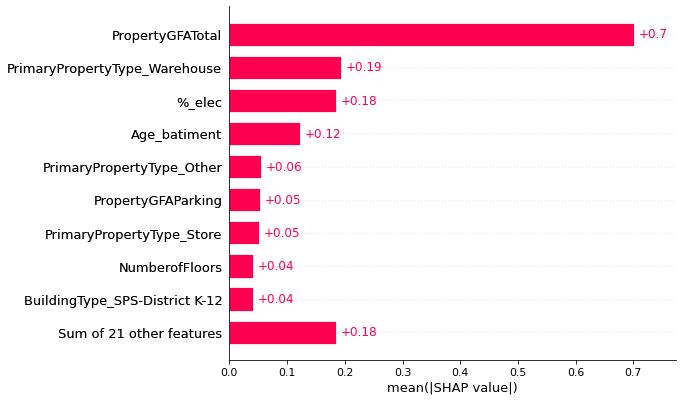

In [62]:
#Moyenne SHAP
shap.plots.bar(shap_values)

Dans l'analyse de nos variables, nous pouvons constater que 4 données apportent la grande majorité du score obtenu dans notre projet tandis que les autres variables ont un apport assez faible dans notre prédiction.

Nous pouvons ici confirmer que le modèle a subi un surajustement à travers un grand nombre de variables ayant un impact faible dans notre projet.

# Conclusion

Dans le cadre de notre projet, le but étant de pouvoir prédire la consommation de CO2 mais aussi d'énergie pour les logements afin de répondre à un critères de neutralité carbone d'ici 2050.

Nous constatons que plusieurs modélisations ont lieu et que notre score maximale tourne autour de 0.73, ce qui reste cohérent pour notre première phase de modélisation. Notre modèle présente une situation de surapprentissage qui sera simplement corrigé par la sélection des paramètres standards dans le cadre de notre projet.

Certaines variables ont un apport faible dans notre modélisation tandis que seuls quelques données ont un apport permettant l'amélioration de notre modèle.

Sur les modèles testés, nous avons utilisé deux possibilités. A savoir, les modèles linéaires standards (régression linéaire par exemple) mais aussi les modèles ensemblistes (XGBoost par exemple). Ces derniers ont tendance à donner de meilleurs résultats pour notre problématique.

Il est important de signaler que nos modèles sont entraînés à travers des données identiques.
Nous remarquons que les données du modèle ne peuvent correspondre parfaitement à nos deux problématiques.

Enfin, nous pouvons constater que certaines données ou informations sont absentes et auraient permis une amélioration de notre connaissance des immeubles mais aussi une amélioration de notre modèle tels que le niveau de rénovation des immeubles (date et nature des travaux) mais également des données liées à l'isolation des immeubles.